In [1]:
using Revise

In [2]:
using Distributed
n_procs = 10
if n_procs > nprocs()
    addprocs(n_procs - nprocs())
end
;

In [3]:
@everywhere using QuantumStates, UnitsToValue

In [56]:
@everywhere begin
    H_X_v0 = load_from_file("CaF_X_v0", "C://Google Drive//github//QuantumStates//Hamiltonians//CaF//")
    H_A_v0 = load_from_file("CaF_A_v0", "C://Google Drive//github//QuantumStates//Hamiltonians//CaF//")
    H_B_v0 = load_from_file("CaF_B_v0", "C://Google Drive//github//QuantumStates//Hamiltonians//CaF//")

    N_max = 3

    # reduce rotational state space
    H_X_v0 = subspace(H_X_v0, (N=0:N_max,))
    H_A_v0 = subspace(H_A_v0, (J=1/2:(N_max+3/2),))
    H_B_v0 = subspace(H_B_v0, (N=0:(N_max+1),))
end
;

In [57]:
@everywhere begin
    QN_bounds = (
        label = "A",
        I = 1/2,
        S = 1/2,
        ℓ = 0,
        Λ = (-1,+1),
        K = (-1,+1),
        N = 1:(N_max+2),
        J = 1/2:(N_max+3/2)
    )
    A_state_caseB_basis = order_basis_by_m(enumerate_states(HundsCaseB_LinearMolecule, QN_bounds))

    H_A_v0_caseB = convert_basis(H_A_v0, A_state_caseB_basis)
    evaluate!(H_A_v0_caseB)
    solve!(H_A_v0_caseB)
end

In [58]:
@everywhere begin 
    w = 20e-6
    P = 10
    I0_trap = 2P / (π * w^2)

    ω0A = 2π * 495e12
    ΓA = 2π * 8.4e6
    d_egA = sqrt( (3*π*ε0*ħ*c^3 / ω0A^3) * ΓA )

    ω0B = 2π * 565e12
    ΓB = 2π * 6.3e6
    d_egB = sqrt( (3*π*ε0*ħ*c^3 / ω0B^3) * ΓB )
end

In [59]:
@everywhere begin
    Hs = [H_X_v0, H_A_v0_caseB, H_B_v0]
    H = CombinedHamiltonian(Hs)

    x = [1.0, 0.0, -1.0] / √2
    y = im * [1.0, 0.0, 1.0] / √2
    z = [0, 1, 0]
    
    # linearly polarized trap
    θ = 0
    ϵ = cos(θ) * [0.0, 1.0, 0.0] + sin(θ) * [1.0, 0.0, -1.0] / √2
    
    # X-A operator
    XA(q) = (state, state′) -> (d_egA / h) * TDM(state, state′, q) * (state.label == "X") * (state′.label == "A")
    XA_conj(q) = (state, state′) -> conj(XA(q)(state′, state))
    
    # X-B operator
    XB(q) = (state, state′) -> (d_egB / h) * TDM(state, state′, q) * (state.label == "X") * (state′.label == "B")
    XB_conj(q) = (state, state′) -> conj(XB(q)(state′, state))

    # A-B operator
    AB(q) = (state, state′) -> (d_egA / h) * TDM(state, state′, q) * (state.label == "A") * (state′.label == "B")
    AB_conj(q) = (state, state′) -> conj(AB(q)(state′, state))

    q = 1; H = add_to_H(H, Symbol("E_trap" * string(q)),
        XA(q-2) + XB(q-2) + AB(q-2) + XA_conj(q-2) + XB_conj(q-2) + AB_conj(q-2)
    )
    q = 2; H = add_to_H(H, Symbol("E_trap" * string(q)),
        XA(q-2) + XB(q-2) + AB(q-2) + XA_conj(q-2) + XB_conj(q-2) + AB_conj(q-2)
    )
    q = 3; H = add_to_H(H, Symbol("E_trap" * string(q)),
        XA(q-2) + XB(q-2) + AB(q-2) + XA_conj(q-2) + XB_conj(q-2) + AB_conj(q-2)
    )

    evaluate!(H)
    solve!(H)
end

### State energies versus trap intensity

In [74]:
@everywhere function H_func_neg!(H, scan_values)
    H.parameters.E_trap1 = ϵ[1] * sqrt(2scan_values[1] / (ε0 * c))
    H.parameters.E_trap2 = ϵ[2] * sqrt(2scan_values[1] / (ε0 * c))
    H.parameters.E_trap3 = ϵ[3] * sqrt(2scan_values[1] / (ε0 * c))
    
    evaluate!(H)
    trap_frequency = c / 1064e-9
    for i ∈ (length(H.Hs[1].states)+1):length(H.states)
        H.matrix[i,i] -= trap_frequency
    end    
    solve!(H)
    
    return nothing
end
@everywhere function H_func_pos!(H, scan_values)
    H.parameters.E_trap1 = ϵ[1] * sqrt(2scan_values[1] / (ε0 * c))
    H.parameters.E_trap2 = ϵ[2] * sqrt(2scan_values[1] / (ε0 * c))
    H.parameters.E_trap3 = ϵ[3] * sqrt(2scan_values[1] / (ε0 * c))
    
    evaluate!(H)
    trap_frequency = c / 1064e-9
    for i ∈ (length(H.Hs[1].states)+1):length(H.states)
        H.matrix[i,i] += trap_frequency
    end    
    solve!(H)
    
    return nothing
end
;

In [77]:
Is = (0:0.015:1) .* I0_trap * 0.05
scan_params = (
    I = Is,
)
iterator = Iterators.product
    
@time scan_values_neg, _ = scan_parameters_v2(H, scan_params, iterator, H_func_neg!, H -> energy.(H.states))
matrix_values_neg = hcat(values(scan_values_neg)...)'
@time scan_values_pos, _ = scan_parameters_v2(H, scan_params, iterator, H_func_pos!, H -> energy.(H.states))
matrix_values_pos = hcat(values(scan_values_pos)...)'

matrix_values = matrix_values_neg .+ matrix_values_pos
Es_rel = matrix_values .- matrix_values[1,:]'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.677967 seconds (668.05 k allocations: 110.144 MiB, 1.44% gc time, 4.99% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.492005 seconds (667.90 k allocations: 110.137 MiB, 0.86% gc time, 5.45% compilation time)


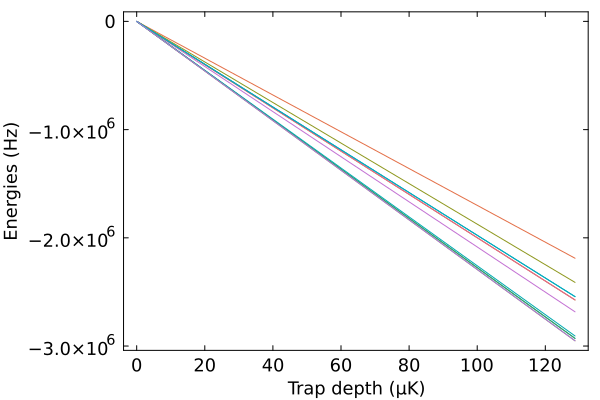

In [79]:
using Plots, LaTeXStrings
trap_depths = abs.((1e6 * h / kB) .* Es_rel)
plot(trap_depths[:,1], Es_rel[:,5:16])

plot!(
    xlabel="Trap depth (μK)",
    ylabel="Energies (Hz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on,
    legend=nothing,
    # ylim=(-1e3,+1e3)
    )

# Solve Hamiltonian in the presence of trap

In [80]:
H.parameters.E_trap1 = 0ϵ[1] * sqrt(2I0_trap / (ε0 * c))
H.parameters.E_trap2 = 0ϵ[2] * sqrt(2I0_trap / (ε0 * c))
H.parameters.E_trap3 = 0ϵ[3] * sqrt(2I0_trap / (ε0 * c))

evaluate!(H)
solve!(H)

ground_state_idxs = 5:16
excited_state_idxs = 69:72
states_idxs = [ground_state_idxs; excited_state_idxs]

states_cooling_sim = H.states[states_idxs]
;

In [81]:
using Serialization
serialize("states_cooling_sim.jl", states_cooling_sim)
;

# Create effective Hamiltonian in laser cooling subspace

In [11]:
@everywhere function create_effective_hamiltonian(g_idxs, e_idxs, H, H_matrix, f_ODT)

    n = length(g_idxs)
    H_eff = zeros(ComplexF64, n, n)

    for _i ∈ 1:n
        for _j ∈ 1:n
            for k ∈ e_idxs
                i = g_idxs[_i]
                j = g_idxs[_j]
                E_ground = energy(H.states[i])
                E_excited = energy(H.states[k])
                H_eff[_i,_j] += H_matrix[i,k] * H_matrix[k,j] / (E_excited - E_ground - f_ODT)
                H_eff[_i,_j] += H_matrix[i,k] * H_matrix[k,j] / (E_excited - E_ground + f_ODT)
            end
        end
    end

    return H_eff
end
;

In [12]:
@everywhere begin
    H_ODT_matrix = ϵ[1] .* H.operators.E_trap1.matrix .+ ϵ[2] .* H.operators.E_trap2.matrix .+ ϵ[3] .* H.operators.E_trap3.matrix

    X_idxs, _ = subspace(H.basis, (label=["X"],))
    A_idxs, _ = subspace(H.basis, (label=["A"],))
    B_idxs, _ = subspace(H.basis, (label=["B"],))

    X_N1_idxs, _ = subspace(H.basis, (label=["X"], N=1,))
    A_J12_idxs, _ = subspace(H.basis, (label=["A"], J=1/2,))
    
    const H_ODT_eff_g = create_effective_hamiltonian(X_N1_idxs, [A_idxs..., B_idxs...], H, H_ODT_matrix, c/1064e-9)
    const H_ODT_eff_e = create_effective_hamiltonian(A_J12_idxs, [X_idxs..., B_idxs...], H, H_ODT_matrix, c/1064e-9)
end
;

In [13]:
@everywhere begin
    HX_eff = subspace(deepcopy(H_X_v0), (N=1,))
    evaluate!(HX_eff)
    solve!(HX_eff)

    HA_eff = subspace(deepcopy(H_A_v0_caseB), (J=1/2,))
    evaluate!(HA_eff)
    solve!(HA_eff)
end
;

In [14]:
@everywhere begin
    H_ODT_matrix_g = create_matrix_for_states(H_ODT_eff_g, HX_eff.states)
    H_ODT_matrix_e = create_matrix_for_states(H_ODT_eff_e, HA_eff.states)
end
;

In [15]:
H_ODT_matrix = zeros(ComplexF64, 16, 16)
H_ODT_matrix[1:12, 1:12] .= H_ODT_matrix_g
H_ODT_matrix[13:16, 13:16] .= H_ODT_matrix_e[5:8, 5:8]
;

In [16]:
H_ODT_matrix[13:16,13:16]

4×4 Matrix{ComplexF64}:
 -2.48825e-6+0.0im          0.0+0.0im          0.0+0.0im          0.0+0.0im
         0.0+0.0im  -2.48827e-6+0.0im          0.0+0.0im          0.0+0.0im
         0.0+0.0im          0.0+0.0im  -2.45594e-6+0.0im          0.0+0.0im
         0.0+0.0im          0.0+0.0im          0.0+0.0im  -2.48827e-6+0.0im

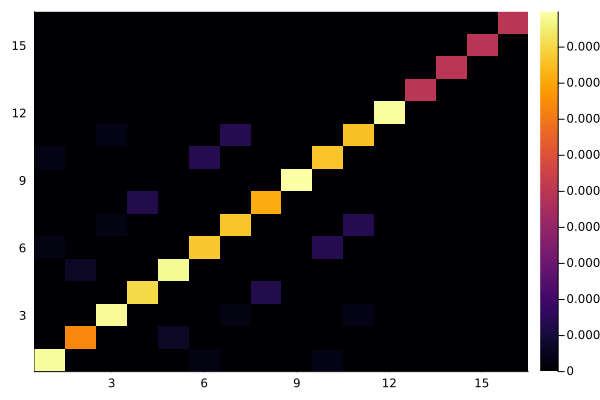

In [17]:
norm.(H_ODT_matrix) |> heatmap

In [18]:
using Serialization
serialize("H_ODT_matrix.jl", H_ODT_matrix)
;

## Let's check the trap shifts versus energy for the effective Hamiltonian for $X(N=1)$

In [19]:
@everywhere function H_func!(H, scan_values)
    evaluate!(H)
    H.matrix .-= sqrt(2scan_values[1] / (ε0 * c))^2 .* H_ODT_eff_g
    solve!(H)
    return nothing
end
;

In [20]:
Is = (0:0.015:1) .* I0_trap
scan_params = (
    I = Is,
)
iterator = Iterators.product
    
@time scan_values, _ = scan_parameters_v2(HX_eff, scan_params, iterator, H_func!, H -> energy.(H.states))
energies = hcat(values(scan_values)...)'
energies_relative = energies .- energies[1,:]'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.227644 seconds (66.54 k allocations: 5.112 MiB, 32.30% compilation time)


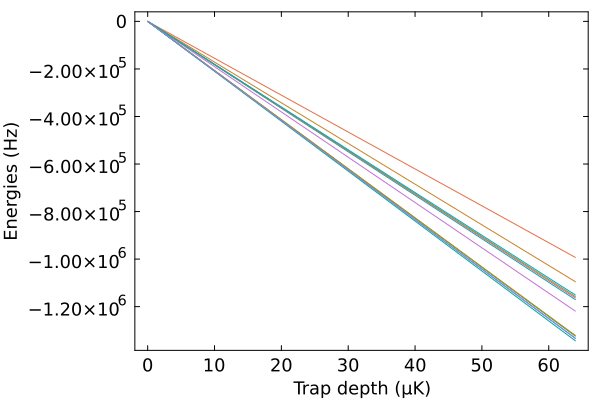

In [21]:
using Plots, LaTeXStrings
trap_depths = abs.((1e6 * h / kB) .* energies_relative)
plot(trap_depths[:,1], energies_relative[:,1:12])

plot!(
    xlabel="Trap depth (μK)",
    ylabel="Energies (Hz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on,
    legend=nothing,
    # ylim=(-1e3,+1e3)
    )